In [2]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import lightgbm
import catboost
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
import shap
import joblib
from sklearn.metrics import r2_score
%matplotlib inline
###########wrapping root mean square error for later calls##########
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
###########loading data##########
fdata=pd.read_csv('finaldatabase.csv',encoding="utf-8")
raw_data=fdata.loc[:,[                     
    'xN2a_in0',#0
    'RH_CC',#1
    'dela_CH (mm)',#2
    'dela_M (um)',#3
    'dela_GDL (um)',#4
    'p_A (atm)',#5
    'T_cc (K)',#6
    'E cell (V)',#7
    'current',#8
    'fyN2',#9
                        ]]
###########train test splitting##########
standardized_data = (raw_data-np.mean(raw_data,axis=0))/np.std(raw_data,axis=0)
raw_input=raw_data.iloc[:,0:8]
raw_output=raw_data.iloc[:,8]
###########fix random seed for reproducability##########
seed=1
X_train, X_test, y_train, y_test = train_test_split(raw_input, raw_output, test_size=.15,random_state=seed)
y_test_values=y_test.values.astype(np.float32)


Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator AdaBoostRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


可决系数 r2_score_current:  0.9300711907649793
方差 rmse_val： 0.1307025012638749


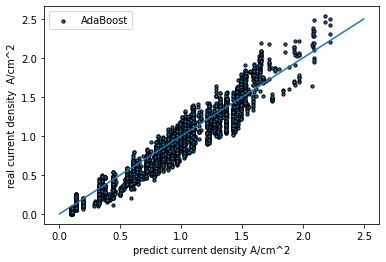

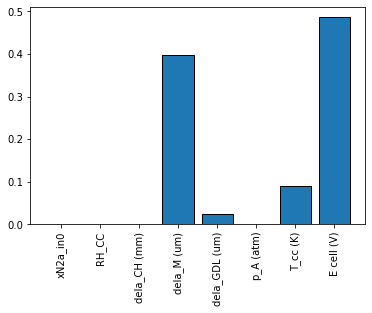

[0.         0.00130073 0.         0.39758156 0.02512944 0.
 0.08972824 0.48626002]


In [5]:
ada_model=joblib.load('ada_model')
algorithm_name='AdaBoost'
result = ada_model.predict(X_test)
x_prediction=result
y_real=y_test_values
x_prediction_series=pd.Series(x_prediction)
y_real_series=pd.Series(y_real)
###########evaluating the regression quality##########

rmse_val= rmse(x_prediction,y_real)
r2_score_current=r2_score(x_prediction,y_real)
print('可决系数 r2_score_current: ',r2_score_current)
print('方差 rmse_val：',rmse_val)

###########generating a figure##########
x_y_x=np.arange(0,2.6,0.1)
x_y_y=np.arange(0,2.6,0.1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_prediction,y_real,edgecolor='black',s=10,label=algorithm_name)
ax.plot(x_y_x,x_y_y)
plt.legend()
plt.xlabel(u"predict current density A/cm^2")
plt.ylabel(u"real current density  A/cm^2")
plt.savefig('%s CurrentdensityRegression.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()
name_list=list(X_test)
plt.bar(range(len(ada_model.feature_importances_)), ada_model.feature_importances_,edgecolor='black',tick_label=name_list)
plt.xticks(rotation=90)
plt.savefig('%s FeatureImportance.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()
print(ada_model.feature_importances_)




In [3]:
##shapvalues caculation

explainer=shap.Explainer(ada_model)
shapvalues=explainer(X_test)
shap_values=explainer.shap_values(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)
expected_value = explainer.expected_value
explainer2 = shap.Explainer(ada_model,X_test)
shap_values2 = explainer(X_test)

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='exponential',
                  n_estimators=50, random_state=1)

In [4]:
explainer=shap.SamplingExplainer(ada_model.predict,X_test)
shapvalues=explainer.shap_values(X_test)

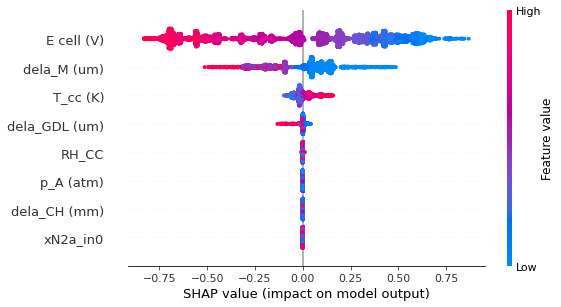

In [10]:
shap.summary_plot(shapvalues,X_test,feature_names=list(X_test))

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value, shapvalues,raw_input)


shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [ ]:
##bar plot
shap.plots.bar(shapvalues[0],max_display=10,show=False)
plt.savefig('%s shapvalues_distribution_single.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##bar plot
shap.plots.bar(shapvalues,max_display=10,show=False)
plt.savefig('%s shapvalues_distribution.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()
print(name_list)
print(shapvalues.abs.mean(0).values)

##bar plot   optimally separate the SHAP values of the instances using a sklearn DecisionTreeRegressor. 
## 2 
shap.plots.bar(shapvalues.cohorts(2).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution2.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##bar plot   optimally separate the SHAP values of the instances using a sklearn DecisionTreeRegressor. 
## 3 
shap.plots.bar(shapvalues.cohorts(3).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution3.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##bar plot   optimally separate the SHAP values of the instances using a sklearn DecisionTreeRegressor. 
## 4 
shap.plots.bar(shapvalues.cohorts(4).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution4.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##bar plot   optimally separate the SHAP values of the instances using a sklearn DecisionTreeRegressor. 
## 5 
shap.plots.bar(shapvalues.cohorts(5).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution5.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##high low feature imortance distribution
j=0
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 0.35 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=1
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 0.5 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=2
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 1.5 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=3
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 250 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=4
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 250 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=5
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 3 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=6
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 340 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

j=7
ka = ["low {}".format(name_list[j]) if shapvalues[i,name_list[j]].data <= 0.6 else "high {}".format(name_list[j]) for i in range(shapvalues.shape[0])]
shap.plots.bar(shapvalues.cohorts(ka).abs.mean(0),show=False)
plt.savefig('%s shapvalues_distribution{}.jpg'.format(name_list[j]) %algorithm_name,bbox_inches = 'tight')
plt.show()

##heatmap
shap.plots.heatmap(shapvalues[:1000],show=False)
plt.savefig('%s shapvalues_heatmap.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

shap.plots.heatmap(shapvalues[:1000], feature_values=shapvalues.abs.max(0),show=False)
plt.savefig('%s shapvalues_heatmap_orderby_max.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

#order by sum shapvalues
shap.plots.heatmap(shapvalues[:1000], instance_order=shapvalues.sum(1)[:1000],show=False)
plt.savefig('%s shapvalues_heatmap_orderby_sum.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##decision plot
shap.decision_plot(expected_value, shap_values[:10], X_test,show=False,highlight=0)
plt.savefig('%s decision_plot10.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##decision plot
shap.decision_plot(expected_value, shap_values[0], X_test,show=False,highlight=0)
plt.savefig('%s decision_plot10_0.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##shap_interaction_values
shap.decision_plot(expected_value, shap_interaction_values[:10], X_test[:10],show=False)
plt.savefig('%s decision_plot10_interactionvalues.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

shap.decision_plot(expected_value, shap_interaction_values[:10], X_test[:10],show=False,feature_display_range=slice(None, None, -1))
plt.savefig('%s decision_plot10_interactionvalues_long.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

shap.decision_plot(expected_value, shap_interaction_values[:1], X_test[:1],show=False,highlight=0)
plt.savefig('%s decision_plot10_interactionvalues_0.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

for i in range(len(list(X_test))):
    shap.dependence_plot("%s"%list(X_test)[i], shap_values[:2000], X_test[:2000],show=False)
    plt.savefig('%s dependence_plot_%s.jpg' %(algorithm_name,list(X_test)[i]),bbox_inches = 'tight')

    
    
##identify typical prediction pahths
y_pred = ada_model.predict(X_test)

T = X_test[(y_pred >= 0)&(y_pred <= 0.01)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)

T = X_test[(y_pred >= 0.3)&(y_pred <= 0.32)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)

T = X_test[(y_pred >= 0.8)&(y_pred <= 0.83)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)

T = X_test[(y_pred >= 1.5)&(y_pred <=1.55)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)

T = X_test[(y_pred >= 2)&(y_pred <= 2.1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)

T = X_test[y_pred >= 2.5]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[:500]
shap.decision_plot(expected_value, sh, T, feature_order='hclust',show=False)



plt.savefig('%s tupical_prediction_path500.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

shap.summary_plot(shap_interaction_values[:1000], X_test[:1000],show=False)
plt.savefig('%s effect_betweenfeatures.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

shap.plots.beeswarm(shap_values2.abs, color="shap_red",show=False)
plt.savefig('%s beenswarm_abs.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

## summarize the effects of all the features
shap.summary_plot(shap_values[:500], X_test[:500],show=False)
plt.savefig('%s feature_effect.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()

##water fall
shap.plots.waterfall(shapvalues[0],show=False)#for the first observation
plt.savefig('%s shapvalues_waterfall.jpg' %algorithm_name,bbox_inches = 'tight')
plt.show()